In [58]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols
from  statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.stats.stats import pearsonr 

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('classic')
plt.rc("figure", facecolor="white")
rcParams['figure.figsize'] = 12, 8



# random seed
random_state=0
rng = np.random.RandomState(seed=random_state)

In [2]:
#load dataset
data_process = pd.read_csv('clean_houses_95.csv',parse_dates=['Time'], index_col='Time')
data = data_process.copy(deep=True)

In [3]:
data = data['2014-04':]

In [4]:
# Create seasonal variables
#data['Year'] = pd.DatetimeIndex(data.index).year
data['Month'] = pd.DatetimeIndex(data.index).month
data['Week'] = pd.DatetimeIndex(data.index).week
data['DayOfMonth'] = pd.DatetimeIndex(data.index).day
#data['DayOfWeek'] =  pd.DatetimeIndex(data.index).dayofweek
data['Day'] = pd.DatetimeIndex(data.index).weekday_name
data['Hour'] =  pd.DatetimeIndex(data.index).hour

In [5]:
# Week days Feature
data.loc[(data['Day'] == 'Monday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Saturday', 'WeekDays')] = 'Saturday'
data.loc[(data['Day'] == 'Sunday', 'WeekDays')] = 'Sunday'
data.loc[(data['Day'] == 'Tuesday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Wednesday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Thursday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Friday', 'WeekDays')] = 'WeekDays'

In [6]:
data_modeling = data.copy(deep=True)

In [7]:
# drop unwanted features
cols = ['Week','Day']
data_modeling = data_modeling.drop(cols, axis=1)

In [8]:
data_modeling.columns

Index(['House_1', 'House_2', 'House_4', 'House_5', 'House_6', 'House_7',
       'House_8', 'House_9', 'House_10', 'House_12', 'House_13', 'House_15',
       'House_16', 'House_17', 'House_18', 'House_19', 'House_20', 'Month',
       'DayOfMonth', 'Hour', 'WeekDays'],
      dtype='object')

In [9]:
# columns for one hot encoding
cols =  ['DayOfMonth', 'Hour', 'WeekDays']

In [10]:
data_modeling.House_18 = data_modeling.House_18.replace(0.0, np.nan)

In [11]:
residuals = pd.DataFrame()
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
for house_nr in houses:
    house = 'House_' + str(house_nr)
    form = 'House_' + str(house_nr) + ' ~ C(Month) + C(DayOfMonth) + C(WeekDays) + C(Hour) -1'
    mod = ols(formula=form, data=data_modeling, missing='drop').fit()
    df = pd.DataFrame(mod.resid,columns=[house],index=mod.resid.index)
    residuals = pd.concat([residuals,df],axis=1)

In [13]:
# keep the same time frame for weather data and resample on hourly level by averaging
weather_process = pd.read_csv('weather_data.csv',parse_dates=True, index_col='dateTime')
weather = weather_process.copy(deep=True)
cols = ['Wind_speed','Wind_direction_D1', 'Wind_direction_SD1', 'Total_horizontal_solar_irradiation', 'NR_Wm2_Avg', 'CNR_Wm2_Avg', 'Average_barometric_pressure']
weather = weather.drop(cols,axis=1)
weather = weather['2014-04-01 00:00:00':'2015-07-10 11:00:00']
weather = weather.resample('H').mean()

In [14]:
all_data = pd.concat([weather,residuals],axis=1)

In [15]:
all_data.columns

Index(['Air_temperature', 'Relative_humidity',
       'Average_horizontal_solar_irradiance', 'Total_rainfall', 'House_1',
       'House_2', 'House_4', 'House_5', 'House_6', 'House_7', 'House_8',
       'House_9', 'House_10', 'House_12', 'House_13', 'House_15', 'House_16',
       'House_17', 'House_18', 'House_19', 'House_20'],
      dtype='object')

In [16]:
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
weather_metrics = ['Air_temperature', 'Relative_humidity','Average_horizontal_solar_irradiance', 'Total_rainfall']
thesaurus = {}
all_results=pd.DataFrame()
for house_nr in houses:
    house = 'House_' + str(house_nr)
    
    data_copied = all_data.copy(deep=True)
    
    # keep the house you want for modeling
    drop_houses = ['House_'+str(i) for i in houses if i != house_nr]
    data_copied = data_copied.drop(drop_houses, axis=1)
    data_copied = data_copied.dropna(axis=0,how='any')
    
    house_load = data_copied[house].values
    
    for metric in weather_metrics:
        weather_var = data_copied[metric].values
        corr_coef = pearsonr(house_load,weather_var)[0]
        thesaurus[metric] = corr_coef

    df1  = pd.DataFrame(thesaurus, index=[house_nr])
    all_results = pd.concat([all_results,df1])

In [18]:
all_results.describe()

,Air_temperature,Average_horizontal_solar_irradiance,Relative_humidity,Total_rainfall
count,17.000000,17.000000,17.000000,17.000000
mean,-0.006806,-0.005557,0.027933,0.015854
std,0.021020,0.024761,0.027239,0.021745
min,-0.030304,-0.058245,-0.028257,-0.023590
25%,-0.018619,-0.019997,0.012906,0.003304
50%,-0.013079,-0.003038,0.024369,0.014932
75%,0.000813,0.008342,0.049705,0.030898
max,0.053138,0.041962,0.074923,0.056833


In [19]:
for metric in weather_metrics:
    key = metric + '-1'
    all_data[key] = all_data[metric].shift(+1)
    key = metric + '-2'
    all_data[key] = all_data[metric].shift(+2)

In [20]:
all_data.columns

Index(['Air_temperature', 'Relative_humidity',
       'Average_horizontal_solar_irradiance', 'Total_rainfall', 'House_1',
       'House_2', 'House_4', 'House_5', 'House_6', 'House_7', 'House_8',
       'House_9', 'House_10', 'House_12', 'House_13', 'House_15', 'House_16',
       'House_17', 'House_18', 'House_19', 'House_20', 'Air_temperature-1',
       'Air_temperature-2', 'Relative_humidity-1', 'Relative_humidity-2',
       'Average_horizontal_solar_irradiance-1',
       'Average_horizontal_solar_irradiance-2', 'Total_rainfall-1',
       'Total_rainfall-2'],
      dtype='object')

In [21]:
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
weather_metrics = ['Air_temperature-1', 'Relative_humidity-1','Average_horizontal_solar_irradiance-1', 'Total_rainfall-1','Air_temperature-2', 'Relative_humidity-2','Average_horizontal_solar_irradiance-2', 'Total_rainfall-2']
thesaurus = {}
all_results=pd.DataFrame()
for house_nr in houses:
    house = 'House_' + str(house_nr)
    
    data_copied = all_data.copy(deep=True)
    
    # keep the house you want for modeling
    drop_houses = ['House_'+str(i) for i in houses if i != house_nr]
    data_copied = data_copied.drop(drop_houses, axis=1)
    data_copied = data_copied.dropna(axis=0,how='any')
    
    house_load = data_copied[house].values
    
    for metric in weather_metrics:
        weather_var = data_copied[metric].values
        corr_coef = pearsonr(house_load,weather_var)[0]
        thesaurus[metric] = corr_coef

    df1  = pd.DataFrame(thesaurus, index=[house_nr])
    all_results = pd.concat([all_results,df1])

In [22]:
all_results

,Air_temperature-1,Air_temperature-2,Average_horizontal_solar_irradiance-1,Average_horizontal_solar_irradiance-2,Relative_humidity-1,Relative_humidity-2,Total_rainfall-1,Total_rainfall-2
1,0.002340,0.002492,0.036962,0.035097,-0.026431,-0.026322,0.012510,0.020926
2,-0.019248,-0.021848,-0.013770,-0.023737,0.018079,0.021621,-0.025555,-0.010935
4,-0.019277,-0.017166,-0.061499,-0.069308,0.076809,0.069288,0.019730,0.002340
5,-0.027502,-0.027009,-0.024394,-0.028341,0.030686,0.028297,0.002266,0.003909
6,-0.022716,-0.025683,0.004275,-0.001964,0.002681,0.008635,-0.009406,-0.007713
7,-0.029325,-0.029938,-0.025538,-0.041710,0.039097,0.039711,0.003610,0.013845
8,-0.029718,-0.028711,0.002756,0.007794,0.011331,0.010096,0.036056,0.031211
9,0.005147,0.007061,-0.010143,-0.014501,0.030940,0.026920,0.037166,0.039560
10,-0.022348,-0.018964,-0.040385,-0.052067,0.070187,0.066529,0.038117,0.044540
12,-0.022764,-0.025702,-0.004222,-0.009718,0.026070,0.033949,0.018487,0.010300


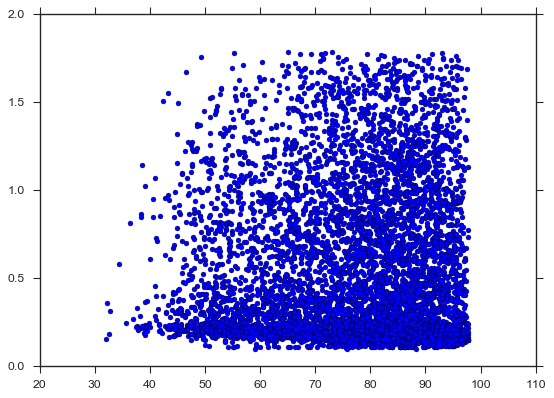

In [69]:
plt.scatter(x=data_temp.Relative_humidity,y=data_temp.House_7)
plt.show()